#  Ball Trajectory Analysis in Tennis

This notebook analyzes ball trajectory data from a tennis clip to detect hit events. The ultimate goal is to train a machine learning model to recognize ball events with precise timestamps.

###  Import Required Libraries

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

### Load Ball Detection Data

In [2]:
# Load the pickle file containing ball detections
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

### Clean and Structure the Ball Position Data

In [3]:
# Extract position lists and convert to DataFrame
ball_positions = [x.get(1,[]) for x in ball_positions]
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# Interpolate and backfill to handle missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

### Calculate Midpoint and Smooth Trajectory

In [4]:
# Compute the vertical midpoint of the ball
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
# Apply a rolling average to smooth the vertical motion
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1).mean()

### Visualize Smoothed Y-Position Over Time

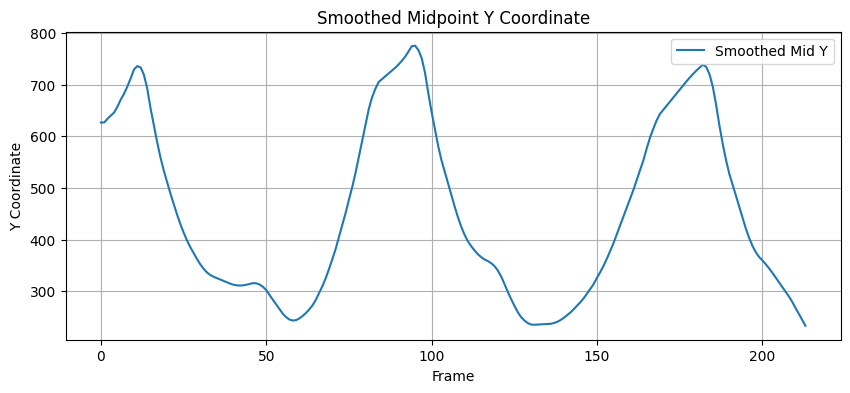

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df_ball_positions['mid_y_rolling_mean'], label='Smoothed Mid Y')
plt.title('Smoothed Midpoint Y Coordinate')
plt.xlabel('Frame')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

### Compute Change in Smoothed Y (ΔY)

In [6]:
# Calculate the difference between consecutive smoothed mid_y values
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

### Visualize ΔY Over Time

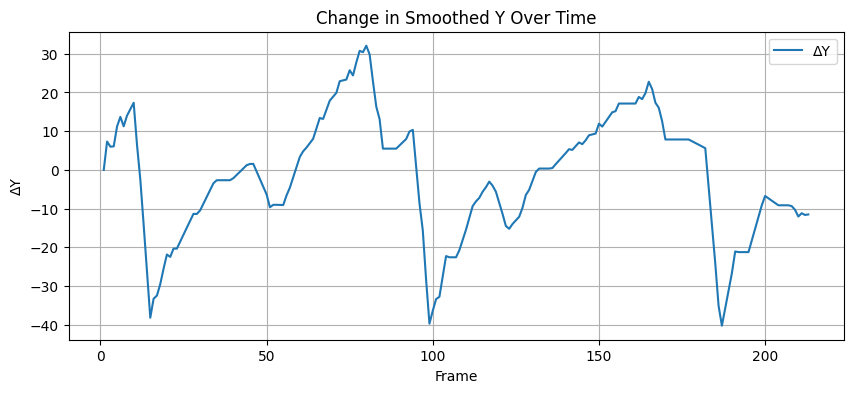

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(df_ball_positions['delta_y'], label='ΔY')
plt.title('Change in Smoothed Y Over Time')
plt.xlabel('Frame')
plt.ylabel('ΔY')
plt.grid(True)
plt.legend()
plt.show()

### Detect Ball Hit Events Based on ΔY Pattern

In [8]:
# Initialize hit detection column
df_ball_positions['ball_hit'] = 0

# Define sensitivity parameter
minimum_change_frames_for_hit = 25

# Loop through frames and detect significant ΔY changes as potential hits
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
            if (negative_position_change and df_ball_positions['delta_y'].iloc[change_frame] < 0) or \
               (positive_position_change and df_ball_positions['delta_y'].iloc[change_frame] > 0):
                change_count += 1
        if change_count > minimum_change_frames_for_hit - 1:
            df_ball_positions.at[i, 'ball_hit'] = 1

In [9]:
# Extract frames where hits are detected
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()

### Frames Detected with Ball Hits

In [10]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.865967,717.330017,796.806519,738.393188,727.861603,735.918115,6.523407,1
58,925.881409,240.971036,939.039478,253.989084,247.480060,243.406101,-1.957850,1
95,624.777161,748.891968,642.157257,766.698242,757.795105,775.403400,0.871759,1
131,716.963562,229.095016,729.239868,242.786224,235.940620,235.241673,-0.557166,1
182,1294.891235,739.127197,1314.160156,760.564819,749.846008,738.733578,5.602832,1


### Plot Ball Trajectory with Hit Points

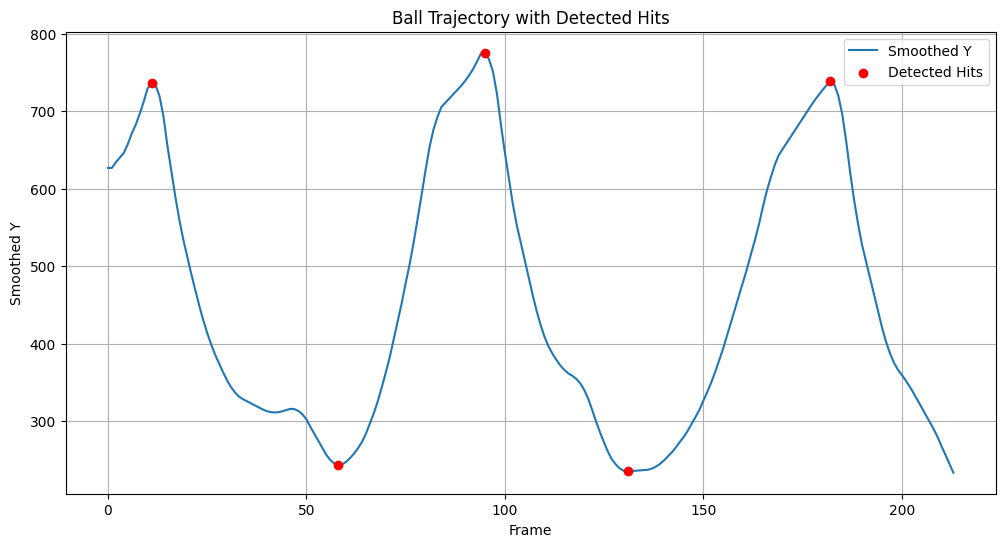

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df_ball_positions['mid_y_rolling_mean'], label='Smoothed Y')
plt.scatter(df_ball_positions[df_ball_positions['ball_hit'] == 1].index, 
            df_ball_positions[df_ball_positions['ball_hit'] == 1]['mid_y_rolling_mean'], 
            color='red', label='Detected Hits', zorder=5)
plt.title('Ball Trajectory with Detected Hits')
plt.xlabel('Frame')
plt.ylabel('Smoothed Y')
plt.grid(True)
plt.legend()
plt.show()